In [1]:
import numpy as np
import dicom
import sys
sys.path.append('..')
import os
from AlgoEngine.ovh import getOVH
from AlgoEngine.utils import getContours
from math import sqrt
import time
start_time = time.time() # For runtime test
import matplotlib.pyplot as plt

## Inputs to Function

In [2]:
BASE_DIR = '/home/radiation/RadiationTherapyDecisionSupport/data/'
PatientID = 'UCLA_PR_5'
n_bins = 10

ctFilenames = [fl for fl in os.listdir(BASE_DIR + PatientID) if 'CT.' in fl]
numImages = len(ctFilenames)

sampleCTImage = dicom.read_file(BASE_DIR + PatientID + '/' + ctFilenames[0])
width = sampleCTImage.Columns
height = sampleCTImage.Rows
row_spacing = float(sampleCTImage.PixelSpacing[0])
column_spacing = float(sampleCTImage.PixelSpacing[1])
slice_spacing = float(sampleCTImage.SliceThickness)

block_shape = (width, height, numImages)
slice_position_z = np.zeros((numImages)).astype(np.float32) 

for i, fl in enumerate(ctFilenames):
    slice_position_z[i] = dicom.read_file(BASE_DIR + PatientID + '/' + fl).ImagePositionPatient[2]

In [3]:
structureset = dicom.read_file(BASE_DIR + PatientID + '/structureset.dcm')
PTV_ROI_NUM = -1
OAR_ROI_NUM = -1

for n in range(0, len(structureset.StructureSetROISequence)):
    if structureset.StructureSetROISequence[n].ROIName == 'PTV':
        PTV_ROI_NUM = structureset.StructureSetROISequence[n].ROINumber
    elif structureset.StructureSetROISequence[n].ROIName == 'Bladder':
        OAR_ROI_NUM = structureset.StructureSetROISequence[n].ROINumber

In [4]:
roiNumPlanes = len(structureset.ROIContourSequence[PTV_ROI_NUM].ContourSequence) 

contour_data = {} 
image_orientation = {} 
image_position = {} 
pixel_spacing = {} 

for index in range(0, roiNumPlanes):
    
    imageSOP = structureset.ROIContourSequence[PTV_ROI_NUM].ContourSequence[index].ContourImageSequence[0].ReferencedSOPInstanceUID
    
    planeContourData = np.array(structureset.ROIContourSequence[PTV_ROI_NUM].ContourSequence[index].ContourData)
    planeContourData = planeContourData.reshape(planeContourData.shape[0] // 3 , 3)
    
    contour_data[imageSOP] = planeContourData
    imagei = dicom.read_file(BASE_DIR + PatientID + '/CT.' + imageSOP + '.dcm')
    
    image_orientation[imageSOP] = imagei.ImageOrientationPatient
    image_position[imageSOP] = imagei.ImagePositionPatient
    pixel_spacing[imageSOP] = imagei.PixelSpacing
ptv_contour_block, ptv_roi_block = getContours(block_shape, slice_position_z, contour_data, image_orientation, image_position, pixel_spacing)

In [5]:
roiNumPlanes = len(structureset.ROIContourSequence[OAR_ROI_NUM].ContourSequence) 

contour_data = {}
image_orientation = {}
image_position = {} 
pixel_spacing = {}

for index in range(0, roiNumPlanes):
    
    imageSOP = structureset.ROIContourSequence[OAR_ROI_NUM].ContourSequence[index].ContourImageSequence[0].ReferencedSOPInstanceUID
    planeContourData = np.array(structureset.ROIContourSequence[OAR_ROI_NUM].ContourSequence[index].ContourData)
    planeContourData = planeContourData.reshape(planeContourData.shape[0] // 3 , 3)
    
    contour_data[imageSOP] = planeContourData
    imagei = dicom.read_file(BASE_DIR + PatientID + '/CT.' + imageSOP + '.dcm')
    
    image_orientation[imageSOP] = imagei.ImageOrientationPatient
    image_position[imageSOP] = imagei.ImagePositionPatient
    pixel_spacing[imageSOP] = imagei.PixelSpacing
_, oar_roi_block = getContours(block_shape, slice_position_z, contour_data, image_orientation, image_position, pixel_spacing)

## Function Starts Here

In [6]:
bin_vals, bin_amts = getOVH(oar_roi_block, ptv_contour_block, ptv_roi_block, pixel_spacing,
                            row_spacing, column_spacing, slice_spacing, n_bins)

## Testing

We assert than the last `bin_amts` is 1.0 (100%), and we plot an OVH histogram

In [7]:
print(bin_amts[-1] == 1.0)

True


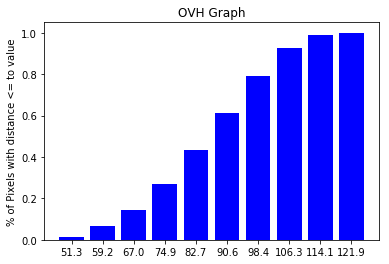

In [8]:
plt.bar(np.arange(len(bin_vals) - 1), bin_amts, align='center', color='blue')
plt.xticks(np.arange(len(bin_vals) - 1), np.around(bin_vals[1:], decimals=1))
plt.ylabel("% of Pixels with distance <= to value")
plt.title("OVH Graph")
plt.show()




In [9]:
print("Runtime of OVH function: " + str((time.time() - start_time)/float(60)) + " Minutes")

Runtime of OVH function: 4.831936542193095 Minutes
